In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils as u
import pandas as pd

/home/aleruzza/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# How to use the emulator

In [2]:
#load the torchscript
emulator = torch.jit.load("model.pth")

Prepare your inputs to the emulator

In [3]:
help(u.norm_labels)

Help on function norm_labels in module utils:

norm_labels(labels)
    Normalizes labels in the correct format that should input to the emulator.
    Provide the unnormalized labels in shape (N, 5) with the parameters in axis=1 in the
    following order:
    PlanetMass, AspectRatio, Alpha, InvStokes1, FlaringIndex



In [4]:
ic = u.generate_ic(1)
p = u.norm_labels([1e-3, 0.05, 1e-4, 10, 0.35])

Use the emulator

In [5]:
out = emulator(ic, p)

In [6]:
out.shape

torch.Size([1, 1, 128, 128])

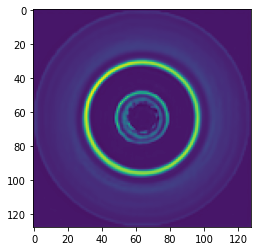

In [7]:
plt.imshow(out[0,0].detach())

# Accuracy of the spiral

In [8]:
paradf = pd.read_csv('../../data/testpara.csv', index_col=0)
para = u.norm_labels(np.array(paradf[['PlanetMass', 'AspectRatio', 'Alpha', 'InvStokes1', 'FlaringIndex']]))
datatest = np.load('../../data/datatest_rot.npy')/1e-5
slopes = np.array(paradf['SigmaSlope'])
ic_inputs = u.generate_ic(slopes)

In [9]:
n = 20
emulations = np.array(emulator(ic_inputs[:n], para[:n]).detach())

In [10]:
emulations.shape

(20, 1, 128, 128)

In [11]:
denormed_em = 10**emulations[:,0]-1

In [12]:
denormed_em.shape

(20, 128, 128)

In [13]:
def getasymm(data):
    xy = np.linspace(-3,3,128)
    r = np.linspace(0.4,3,200)
    prof = u.getprofile(data,xy,xy,r, mode='cart')
    sym = u.generate_sym(r, prof)
    return data-sym

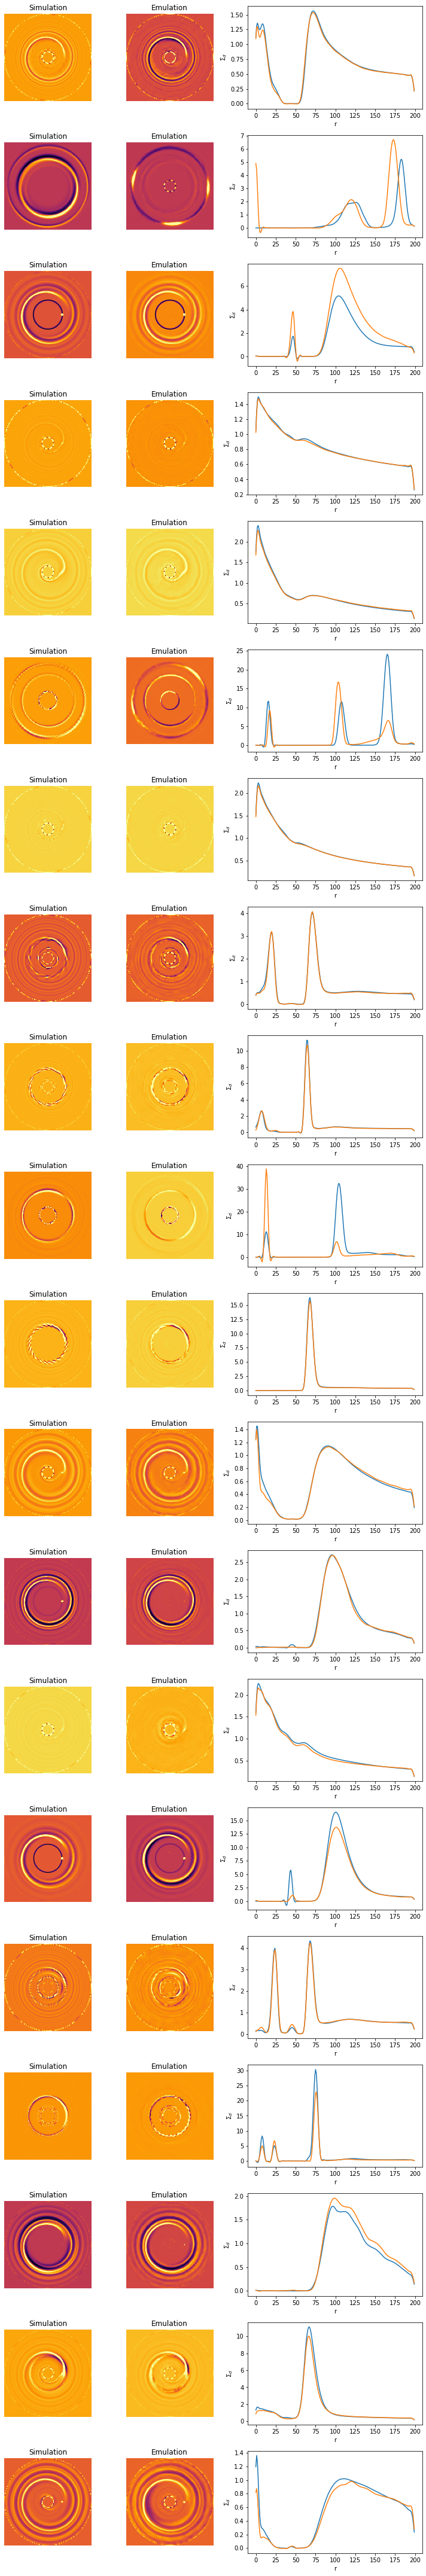

In [15]:
fig, axs = plt.subplots(n, 3, figsize=(10, n*3), width_ratios= [1,1,2])
xy = np.linspace(-3,3,128)
r = np.linspace(0.4,3,200)
for i in range(n):
    axs[i, 0].set_title('Simulation')
    axs[i, 1].set_title('Emulation')
    axs[i, 0].imshow(getasymm(datatest[i]), vmax=np.percentile(getasymm(datatest[i]), 99), cmap='inferno')
    axs[i, 1].imshow(getasymm(denormed_em[i]), vmax=np.percentile(getasymm(denormed_em[i]), 99), cmap='inferno')
    axs[i, 2].plot(u.getprofile(datatest[i], xy, xy, r, mode='cart'))
    axs[i, 2].plot(u.getprofile(denormed_em[i], xy, xy, r, mode='cart'))
    axs[i, 2].set_xlabel('r')
    axs[i, 2].set_ylabel('$\Sigma_d$')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.savefig('gallery.png', dpi=300)

In [ ]:
plt.imshow(getasymm(datatest[0]))

In [ ]:
datatest